## Домашняя работа 2

### Поляков Григорий M05-115a

В данной работе рассматривается графовый рекоммендательный алгоритм из статьи [Graph Convolutional Matrix Completion
](https://arxiv.org/pdf/1706.02263v2.pdf)

#### Краткое описание алгоритма

Дана разреженная матрица оценок пользователями товараов размера $(N_u, N_v)$, где $N_u$ - количество пользователей, $N_v$ - количество товаров. Наблюдаемые оценки - числа {1, ..., r}, ненаблюдаемые отмечены нулем. Требуется по наблюдаемым значениям восстановаить ненаблюдаемыею

#### Загрузим данные

Для начала попробуем воспроизвести результаты статьи на датасете [MovieLens 100K](https://grouplens.org/datasets/movielens/100k/)

#### Скачаем датасет

In [46]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from random import sample
import matplotlib.pyplot as plt
from IPython import display

import torch
from torch.utils.data import BatchSampler, SequentialSampler

url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
request = urlopen(url)

with ZipFile(BytesIO(request.read())) as zip_ref:
    zip_ref.extractall('./')

#### Построим по данным матрицу смежности графа

Оценки пользователями фильмов лежат в файле `u.data`

In [4]:
data = pd.read_csv('./ml-100k/u.data', sep='\t', 
                   header=None, 
                   names=['user', 'item', 'rating', 'timestamp'], 
                   encoding = 'latin-1')
data.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Информация о пользователях и фильмах в файлах `u.item` и `u.user`

In [7]:
movie_data = pd.read_csv('./ml-100k/u.item', sep=r'|', header=None, encoding = 'latin-1')
user_data = pd.read_csv('./ml-100k/u.user', sep=r'|', header=None, encoding = 'latin-1')
num_users = user_data.shape[0]
num_items = movie_data.shape[0]

print(f'Number of users: {num_users}')
print(f'Number of films: {num_items}')

Number of users: 943
Number of films: 1682


В данном датафрейме лежит список ребер рассматриваемого графа.
Разделим его на трейн и валидацию

In [8]:
train, val = train_test_split(data[['user', 'item', 'rating']].values, test_size=0.2, random_state=42)
train = torch.tensor(train, dtype=torch.long)
val = torch.tensor(val, dtype=torch.long)
print(f'Number of edges in train: {train.shape[0]}')
print(f'Number of edges in val: {val.shape[0]}')

Number of edges in train: 80000
Number of edges in val: 20000


Составим по списку ребер 5 матриц смежности, где в $i$-й матрице элемент $(j, k)$ будет равен 1, если пользователь $j$ поставил фильму $k$ оценку $i$.

In [9]:
def make_adj_matrix(num_users, num_items, edges_list, num_classes=5):
    adj_matrix = torch.zeros(num_users, num_items, dtype=torch.long)
    adj_matrix[edges_list[:, 0]-1, edges_list[:, 1]-1] = edges_list[:, 2]
    
    adj_matrices_class = []
    for cl in range(1, num_classes+1):
        adj_matrix_class = torch.zeros(num_users, num_items)
        adj_matrix_class[adj_matrix == cl] = 1
        adj_matrices_class.append(adj_matrix_class)
    return torch.stack(adj_matrices_class, 0)

In [10]:
train_adj_matr = make_adj_matrix(num_users, num_items, train)
val_adj_matr = make_adj_matrix(num_users, num_items, val)

#### Имплементируем основной алгоритм

In [37]:
class MessagePassing(torch.nn.Module):
    def __init__(self, num_classes, embedding_dim, hidden_dim):
        super(MessagePassing, self).__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        
        # применение линейного слоя для каждого типа рейтинга перед message passing (W_r)
        self.rating_linear = torch.nn.Parameter(torch.Tensor(num_classes, embedding_dim, embedding_dim))
        self.playlist_song_linear = torch.nn.Parameter(torch.Tensor(2, embedding_dim, hidden_dim))
        torch.nn.init.normal_(self.rating_linear, std=0.1)
        torch.nn.init.normal_(self.playlist_song_linear, std=0.1)
        
        self.relu = torch.nn.ReLU()
    
    def normalize(self, mx):
        # применение симметричной нормализации в зависимости от числа соседей перед message passing
        rowsum = torch.sum(mx, 0)
        r_inv = torch.pow(rowsum, -0.5)
        r_inv[torch.isinf(r_inv)] = 0.
        r_mat_inv = torch.diag(r_inv)
        colsum = torch.sum(mx, 1)
        c_inv = torch.pow(colsum, -0.5)
        c_inv[torch.isinf(c_inv)] = 0.
        c_mat_inv = torch.diag(c_inv)

        output = torch.matmul(mx, r_mat_inv)
        output = torch.matmul(c_mat_inv, mx)
        return output
    
    def forward(self, playlist_embeddings, song_embeddings, playlists, songs, adj_matrices):
        assert self.num_classes == adj_matrices.shape[0]
        
        all_playlist_embeddings = []
        all_song_embeddings = []
        for i in range(adj_matrices.shape[0]):
            # для каждого типа рейтинга производим свой message passing
            adj_matrix = adj_matrices[i]
            norm = self.normalize(adj_matrix)
            playlist_norms = norm[playlists]
            song_norms = norm.T[songs]
            
            # преобразовываем эмбеддинг каждой ноды и складываем с нормализованными весами
            new_playlist_embeddings = playlist_norms @ (song_embeddings @ self.rating_linear[i])
            new_song_embeddings = song_norms @ (playlist_embeddings @ self.rating_linear[i])
            
            all_playlist_embeddings.append(new_playlist_embeddings)
            all_song_embeddings.append(new_song_embeddings)
        
        # суммируем эмбеддинги для по всем классам
        all_playlist_embeddings = torch.stack(all_playlist_embeddings, 0).sum(0)
        all_song_embeddings = torch.stack(all_song_embeddings, 0).sum(0)
        
        # линейное преобразование эмбедддингов пользователей и товаров по одтельности
        all_playlist_embeddings = self.relu(all_playlist_embeddings @ self.playlist_song_linear[0])
        all_song_embeddings = self.relu(all_song_embeddings @ self.playlist_song_linear[0])

        return all_playlist_embeddings, all_song_embeddings


class Decoder(torch.nn.Module):
    def __init__(self, num_classes, embedding_dim):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        
        # билинейное преобразование эмбеддингов пользователей и товаров в зависимости от класса
        self.bilinear_operator = torch.nn.Parameter(torch.Tensor(self.num_classes,
                                                                 self.embedding_dim,
                                                                 self.embedding_dim))
        torch.nn.init.normal_(self.bilinear_operator, std=0.1)
        
    def forward(self, playlist_features, song_features):
        output = []
        for i in range(self.num_classes):
            output.append(playlist_features @ self.bilinear_operator[i] @ song_features.T)
        return torch.stack(output, 0)

    
class GAE(torch.nn.Module):
    def __init__(self, num_playlists, num_songs, num_classes,
                 embedding_dim, hidden_dim, dropout=0.7):
        super(GAE, self).__init__()
        self.num_playlists = num_playlists
        self.num_songs = num_songs
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        
        # начальное приближение эмбеддингов нод пользователей и товаров
        self.playlist_embeddings = torch.nn.Parameter(torch.Tensor(self.num_playlists, self.embedding_dim))
        self.song_embeddings = torch.nn.Parameter(torch.Tensor(self.num_songs, self.embedding_dim))
        torch.nn.init.normal_(self.playlist_embeddings, std=0.1)
        torch.nn.init.normal_(self.song_embeddings, std=0.1)
        
        # энкодер и декодер
        self.graph_conv = MessagePassing(num_classes, embedding_dim, hidden_dim)
        self.decoder = Decoder(num_classes, hidden_dim)
        self.softmax =  torch.nn.Softmax(dim=0)
    
    def forward(self, playlists, songs, adj_matrix):
        playlist_embeddings, song_embeddings = self.graph_conv(self.playlist_embeddings, self.song_embeddings,
                                                               playlists, songs, adj_matrix)
        scores = self.decoder(playlist_embeddings, song_embeddings)
        scores = self.softmax(scores)
        return scores, self.ratings_from_scores(scores)
    
    def ratings_from_scores(self, scores):
        ratings = (scores * torch.tensor(range(self.num_classes)).reshape(-1, 1, 1)).sum(0)
        return ratings
    
    def predict(self, playlist):
        playlist_emb = self.playlist_embeddings[playlist].unsqueeze(0)
        scores = self.decoder(playlist_emb, self.song_embeddings)
        scores = self.softmax(scores)
        print(scores.shape)
        return self.ratings_from_scores(scores)

#### Лосс, метрики и пайплайн обучения

In [51]:
def rmse(preds, target):
    nonzero = target.sum(axis=0)
    labels = torch.max(target, 0)[1].float() + 1
    
    return torch.sqrt((nonzero * (preds - labels)**2).sum() / nonzero.sum())


def loss(probs, target):
    probs = probs.reshape(probs.shape[0], -1)
    target = target.reshape(target.shape[0], -1)
    target_class = target.max(dim=0)[1]
    
    return torch.nn.functional.cross_entropy(probs, target) / target.sum()


def train(model, adj_matrix, num_playlists, num_songs, optim):
    model.train()
    optim.zero_grad()
    probs, predictions = model(torch.tensor(range(num_playlists)),
                               torch.tensor(range(num_songs)),
                               adj_matrix.clone())
    curr_loss = loss(probs, adj_matrix)
    curr_rmse = rmse(predictions, adj_matrix)
    curr_loss.backward()
    optim.step()
    return curr_loss, curr_rmse

def evaluate(model, adj_matrix, num_playlists, num_songs):
    model.eval()
    u = torch.tensor(range(num_playlists))
    v = torch.tensor(range(num_songs))
    
    probs, predictions = model(u, v, adj_matrix.clone())
    return loss(probs, adj_matrix), rmse(predictions, adj_matrix)

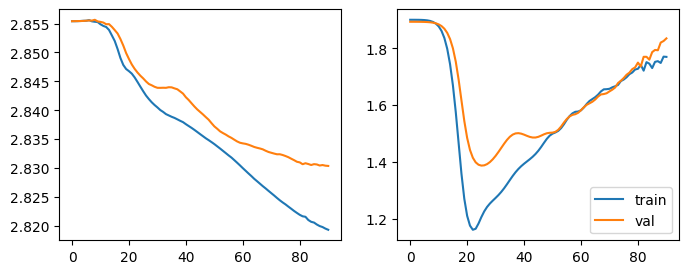

In [55]:
model = GAE(num_users, num_items, train_adj_matr.shape[0], 10, 5)
optim = torch.optim.Adam(model.parameters(), lr=5e-3)

train_losses = []
train_rmses = []
val_losses = []
val_rmses = []
for epoch in tqdm(range(100)):
    train_loss, train_rmse = train(model, train_adj_matr,
                                   num_users, num_items, optim)
    val_loss, val_rmse = evaluate(model, val_adj_matr, num_users, num_items)
    train_losses.append(train_loss.detach().numpy())
    val_losses.append(val_loss.detach().numpy())
    train_rmses.append(train_rmse.detach().numpy())
    val_rmses.append(val_rmse.detach().numpy())
    
    if epoch > 0 and epoch % 10 == 0:
        plt.figure(figsize=(8, 3))
        plt.subplot(121)
        plt.plot(train_losses, label='train')
        plt.plot(val_losses, label='val')
        plt.subplot(122)
        plt.plot(train_rmses, label='train')
        plt.plot(val_rmses, label='val')
        plt.legend()
        plt.show()
        ply.
        display.clear_output(wait=True)

#### Поэксперементируем теперь с музыкальным рекоммендательным датасетом

In [ ]:
# из https://github.com/fmonti/mgcnn
def load_matlab_file(path_file, name_field):
    """
    load '.mat' files
    inputs:
        path_file, string containing the file path
        name_field, string containig the field name (default='shape')
    warning:
        '.mat' files should be saved in the '-v7.3' format
    """
    db = h5py.File(path_file, 'r')
    ds = db[name_field]
    try:
        if 'ir' in ds.keys():
            data = np.asarray(ds['data'])
            ir   = np.asarray(ds['ir'])
            jc   = np.asarray(ds['jc'])
            out  = sp.csc_matrix((data, ir, jc)).astype(np.float32)
    except AttributeError:
        # Transpose in case is a dense matrix because of the row- vs column- major ordering between python and matlab
        out = np.asarray(ds).astype(np.float32).T

    db.close()

    return out